# Assess How Predictions Change
Look at the results that are from predictions in each batch, measure errors and look at the variances

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import json

## Load Runs
Get the data from the productive-level runs

In [2]:
runs = list(Path("prod-runs").glob("*"))

In [3]:
def get_run_data(path: Path):
    """Get the data about a run
    
    Args:
        path: Path to the run
    Returns:
        (dict) Data about the run
    """
    
    # Get the basic information
    output = dict(path=path, study=path.name.split("_")[-1])
    with open(path.joinpath('run_params.json')) as fp:
        run_params = json.load(fp)
    output['num_nodes'] = run_params['nnodes']
    for k in ['random', 'retrain_frequency']:
        output[k] = run_params[k]
    
    # Get the start-time
    with open(path.joinpath('runtime.log')) as fp:
        line = fp.readline().strip()
        start_time = datetime.strptime(line.split(" - ")[0].strip(), "%Y-%m-%d %H:%M:%S,%f")
    
    # Get the molecules that were scanned
    with open(path.joinpath('moldata-records.json')) as fp:
        records = [
            json.loads(x)  # First record is the save time
            for x in fp
        ]
        output['time'] = [(datetime.fromtimestamp(x[0]) - start_time).total_seconds() for x in records]
        mol_data = [json.loads(x[1]) for x in records]
    output['molecules'] = [x['identifier']['smiles'] for x in mol_data]
    output['ip'] = [x['oxidation_potential'].get('smb-vacuum') for x in mol_data]
    
    # Get the predictions and standard deviations for each successful run
    sim_records = pd.read_json(path.joinpath('simulation-results.json'), lines=True).query('success')
    output['pred_mean'] = sim_records['task_info'].apply(lambda x: x.get('mean')).values
    output['pred_std'] = sim_records['task_info'].apply(lambda x: x.get('std')).values
    output['pred_batch'] = sim_records['task_info'].apply(lambda x: x.get('batch')).values
    return output

In [4]:
results = pd.DataFrame([get_run_data(x) for x in runs]).query('not random')

## Compare Initial Only vs Retraining
See how the predictions change with batch

In [5]:
subset = results.query('num_nodes == 256')

In [6]:
no_retrain = subset.query('retrain_frequency>=1000').iloc[0]

In [7]:
retrain = subset.sort_values('retrain_frequency').iloc[0]

In [8]:
retrain

path                                     prod-runs/256-nodes_retrain-8
study                                                        retrain-8
num_nodes                                                          256
random                                                           False
retrain_frequency                                                    8
time                 [1384.257589, 1577.698727, 1589.415107, 1603.2...
molecules            [Fc1cc(F)ncn1, Fc1ccnc(F)n1, O=c1cc(F)oc(F)c1,...
ip                   [9.894218045390485, 10.337883133156366, 9.2167...
pred_mean            [8.257448196411133, 8.278129577636719, 8.03619...
pred_std             [0.278163254261016, 0.266804158687591, 0.26189...
pred_batch           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 0, dtype: object

Plot the retrain as a function of batch

In [9]:
retrain_mols = pd.DataFrame(retrain[['molecules', 'ip', 'pred_mean', 'pred_std', 'pred_batch']].to_dict())
retrain_mols['error'] = (retrain_mols['ip'] - retrain_mols['pred_mean']).abs()

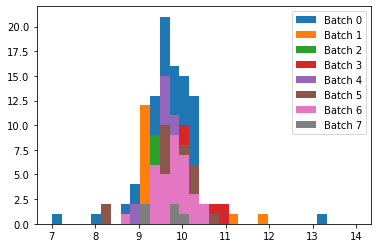

In [10]:
fig, ax = plt.subplots()

bins = np.linspace(7, 14, 32)
for gid, group in retrain_mols.groupby('pred_batch'):
    ax.hist(group['ip'], bins=bins, label=f'Batch {gid}', density=False)
    
ax.legend()

In [12]:
retrain_mols.groupby('pred_batch').median()

,ip,pred_mean,pred_std,error
pred_batch,,,,
0,9.707714,7.999272,0.256844,1.732555
1,9.585629,7.897513,0.150985,1.762297
2,9.619071,8.136994,0.149908,1.589365
3,9.880852,7.843665,0.166777,2.030425
4,9.788958,8.040187,0.174728,1.742482
5,9.803462,7.998921,0.167944,1.945758
6,9.789197,7.877638,0.151240,1.836036
7,9.732908,7.908713,0.123279,1.702276
